# Introducción

En el siguiente documento, se detalla el plan de trabajo para la empresa _Interconnect_ quien ofrece servicios de telefonía. El requerimiento, se centra en la construcción de un modelo que sea capaz de predecir qué clientes tienen mayor probabilidad de cancelar sus servicios (churn) para implementar estrategias proactivas de retención. 


### 1.1 Plan de Trabajo

Este plan está diseñado para desarrollar un modelo de predicción de churn que identifique a los clientes en riesgo de cancelación, permitiendo al equipo de marketing ofrecer incentivos personalizados (como códigos promocionales o ajustes en los planes). El proceso se divide en cuatro fases clave:

1. **Análisis Exploratorio de Datos (EDA)**

    - Objetivo: Entender la estructura, calidad y relaciones entre los datasets.
    - Acciones:
        - Cargar y unir los datasets usando `customerID`.
        - Verificar valores nulos, duplicados y outliers.
        - Analizar distribuciones de variables clave (ej: antigüedad, tipo de contrato).
        - Visualizar correlaciones entre características y cancelación (Churn).
        - Correlación con la variable objetivo Churn (porcentaje de cancelación).
        - Revisión de desbalance de clases

2. **Preprocesamiento de Datos**

    - Objetivo: Preparar los datos para el modelo.
    - Acciones:
        - Limpieza:
            - Imputar nulos (ej: mediana para numéricas, moda para categóricas).
            - Eliminar columnas irrelevantes (ej: IDs no útiles).
        - Transformación:
            - Codificar variables categóricas (ContractType, PaymentMethod con pd.get_dummies()).
            - Escalar numéricas (StandadScaler)
        - Feature Engineering -> Se crean nuevas variables para el análisis
            - Crear nuevas variables (ej: TotalServices = suma de servicios contratados).
            - Extraer antigüedad del cliente desde fechas.
        - Selección de vairables (Feature Selection):
            - Filtering: eliminar columnas con varianza nula.
            - Wrapper: RFE con modelos de baseline.
            - Embedding: usar pesos internos de modelos como Random Forest o XGBoost para medir importancia.
        
3. **Modelado**

    - Objetivo:  Construir y evaluar modelos predictivos.
    - Acciones: 
        - División de dataset en entrenamiento/test
        - Aplicar técanicas para desbalance de clases:
            - smote
            - RandomUnderSampler 
    - Modelos a probar:
        - Regresión Logística (baseline)
        - Random Forest (para importancia de features)
        - XGBoost (optimización de hiperparámetros)
        - Red Neuronal (si hay suficientes datos)
        - Otros
    - Métricas clave:
        - Precisión, Recall (evitar falsos negativos: clientes que se irán pero no detectamos).
        - ROC-AUC (equilibrio entre sensibilidad y especificidad).

4. **Implementación**

    - Objetivo:  Hacer deploy del modelo y recomendar estrategias
    - Acciones:
        - Hacer deploy o implementación del modelo a modo que quede disponible para _Interconnect_ de la forma que ellos consideren pertinente
        - Analizar importancia de variables (feature_importances_).
        - Segmentar y categorizar a los clientes de alto riesgo (ej: contratos mensuales + antigüedad baja). -> construir un "churn persona"

Dado el objetivo del negocio (evitar pérdida de clientes), la métrica prioritaria será el Recall, para minimizar falsos negativos (clientes que se van y no fueron detectados).

### 1.2. Preguntas al demandante

1. Sobre los objetivos del modelo:
    
    1.1. ¿Qué nivel de precisión consideran aceptable para el modelo?
    
    1.2. ¿Prefieren priorizar identificar la mayor cantidad de clientes en riesgo (alto recall), aunque haya falsos positivos, o minimizar errores (alta precisión)?
2. ¿Cuál es el plazo esperado para tener un modelo funcional?
3. Sobre los Datos y Contexto de Negocio:

    3.1. ¿Cómo definen exactamente un caso de churn?

    3.2. ¿Existen restricciones legales o de privacidad para usar ciertos datos personales? (Ejemplo: ¿Podemos usar edad o ubicación geográfica?)
4. ¿Dispondremos de datos actualizados periódicamente para reentrenar el modelo?
5. ¿Cómo se imaginan la integración del modelo? Necesitan una página web, que sea vía API, etc..

### 2. Exploratory Data Analysis

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import warnings




In [2]:
file_path_contract = os.path.join("datasets", "contract.csv")
file_path_internet = os.path.join("datasets", "internet.csv")
file_path_personal = os.path.join("datasets", "personal.csv")
file_path_phone = os.path.join("datasets", "phone.csv")

# Cargar los DataFrame
df_contract = pd.read_csv(file_path_contract)
df_internet = pd.read_csv(file_path_internet)
df_personal = pd.read_csv(file_path_personal)
df_phone = pd.read_csv(file_path_phone)


df_dictionary = {
    "contract": df_contract,
    "internet": df_internet,
    "personal": df_personal,
    "phone": df_phone,

}


#mostrar los primeros 5 registros de cada DataFrame
for key, df in df_dictionary.items():
    print(f"Primeros 5 registros de {key}:")
    print(df.head())
    print("\n")


Primeros 5 registros de contract:
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  


Primeros 5 registros de internet:
   customerID InternetService OnlineSecurity OnlineBackup DeviceProtect

In [3]:
# contemos las filas duplicadas
for key, df in df_dictionary.items():
    print(f"Print duplicated {key}:")
    print(df.duplicated().sum())
    print("\n")

Print duplicated contract:
0


Print duplicated internet:
0


Print duplicated personal:
0


Print duplicated phone:
0




Si bien los DF no tienen valores nulos ni duplicados, debemos corregir el tipo de dato de los siguientes atributos:

- `df_contract`:
    - `BeginDate`: Date
    - `EndDate`: Date
    - `PaperlessBilling`: Bool
    - `TotalCharges`: Float
- `df_internet`: 
    - `OnlineSecurity`: Bool
    - `OnlineBackup`: Bool
    - `DeviceProtection`: Bool
    - `TechSupport`: Bool
    - `StreamingTV`: Bool 
    - `StreamingMovies`: Bool
- `df_personal`:
    - `Partner`: Bool
    - `Dependents`: Bool
- `df_phone`:
    - `Multiplelines`: Bool


In [4]:
# Actualización del tipo de dato de las columnas

# Contract df

df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], errors='coerce')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')
df_contract['PaperlessBilling'] = df_contract['PaperlessBilling'].astype(bool).astype(int)
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(bool).astype(int)

# Internet df
df_internet['OnlineSecurity'] = df_internet['OnlineSecurity'].astype(bool).astype(int)
df_internet['OnlineBackup'] = df_internet['OnlineBackup'].astype(bool).astype(int)
df_internet['DeviceProtection'] = df_internet['DeviceProtection'].astype(bool).astype(int)
df_internet['TechSupport'] = df_internet['TechSupport'].astype(bool).astype(int)
df_internet['StreamingTV'] = df_internet['StreamingTV'].astype(bool).astype(int)
df_internet['StreamingMovies'] = df_internet['StreamingMovies'].astype(bool).astype(int)

# Personal df
df_personal['Partner'] = df_personal['Partner'].astype(bool).astype(int)
df_personal['Dependents'] = df_personal['Dependents'].astype(bool).astype(int)

# Phone df
df_phone['MultipleLines'] = df_phone['MultipleLines'].astype(bool).astype(int)



/var/folders/y_/4wwc4n5d2b70xpd8w5t_sk3m0000gn/T/ipykernel_4489/214035203.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], errors='coerce')


In [5]:
# arreglemos el nombre de las columnas PARA QUE SEAN MINUSCULAS
for key, df in df_dictionary.items():
    df.columns = df.columns.str.lower()
    
    
for key, df in df_dictionary.items():
    print(f"Print info {key}:")
    print(df.info())
    print("\n")   
    

Print info contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   int64         
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 440.3+ KB
None


Print info internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5

In [6]:

# Merge de los DF
df_merge = df_contract.merge(df_internet, on="customerid", how="left")
df_merge = df_merge.merge(df_personal, on="customerid", how="left")
df_merge = df_merge.merge(df_phone, on="customerid", how="left")


df_dictionary["merge"] = df_merge
# Mostrar los primeros 5 registros del DataFrame combinado
print("Primeros 5 registros del DataFrame combinado:")
print(df_merge.head())

Primeros 5 registros del DataFrame combinado:
   customerid  begindate    enddate            type  paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month                 1   
1  5575-GNVDE 2017-04-01        NaT        One year                 1   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01        NaT        One year                 1   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

               paymentmethod  monthlycharges  totalcharges internetservice  \
0           Electronic check           29.85             1             DSL   
1               Mailed check           56.95             1             DSL   
2               Mailed check           53.85             1             DSL   
3  Bank transfer (automatic)           42.30             1             DSL   
4           Electronic check           70.70             1     Fiber optic   

   onlinesecurity  onlinebackup  deviceprotect

In [7]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   int64         
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   int64         
 8   internetservice   5517 non-null   object        
 9   onlinesecurity    5517 non-null   float64       
 10  onlinebackup      5517 non-null   float64       
 11  deviceprotection  5517 non-null   float64       
 12  techsupport       5517 non-null   float64       
 13  streamingtv       5517 non-null   float64       
 14  streamingmovies   5517 n

Identificaremos los clientes churn como aquellos que tengan fecha de termino de su contrato, en este sentido:

In [8]:
df_merge["churn"] = df_merge["enddate"].notna().astype(int)
print(df_merge.head())

   customerid  begindate    enddate            type  paperlessbilling  \
0  7590-VHVEG 2020-01-01        NaT  Month-to-month                 1   
1  5575-GNVDE 2017-04-01        NaT        One year                 1   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month                 1   
3  7795-CFOCW 2016-05-01        NaT        One year                 1   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month                 1   

               paymentmethod  monthlycharges  totalcharges internetservice  \
0           Electronic check           29.85             1             DSL   
1               Mailed check           56.95             1             DSL   
2               Mailed check           53.85             1             DSL   
3  Bank transfer (automatic)           42.30             1             DSL   
4           Electronic check           70.70             1     Fiber optic   

   onlinesecurity  ...  deviceprotection  techsupport  streamingtv  \
0             1.0  ...

/var/folders/y_/4wwc4n5d2b70xpd8w5t_sk3m0000gn/T/ipykernel_4489/4047770069.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merge, x='internetservice', y='monthlycharges', palette="Set2")


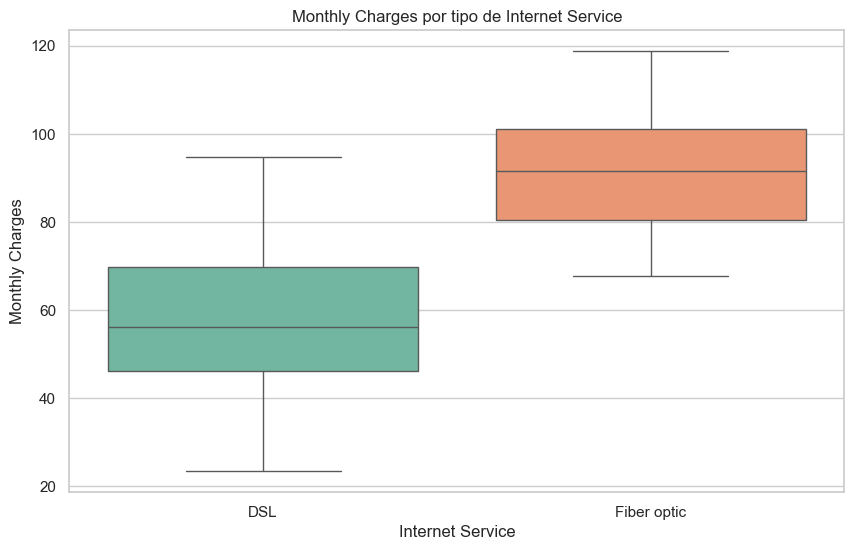

/var/folders/y_/4wwc4n5d2b70xpd8w5t_sk3m0000gn/T/ipykernel_4489/4047770069.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_merge, x='type', palette='pastel')


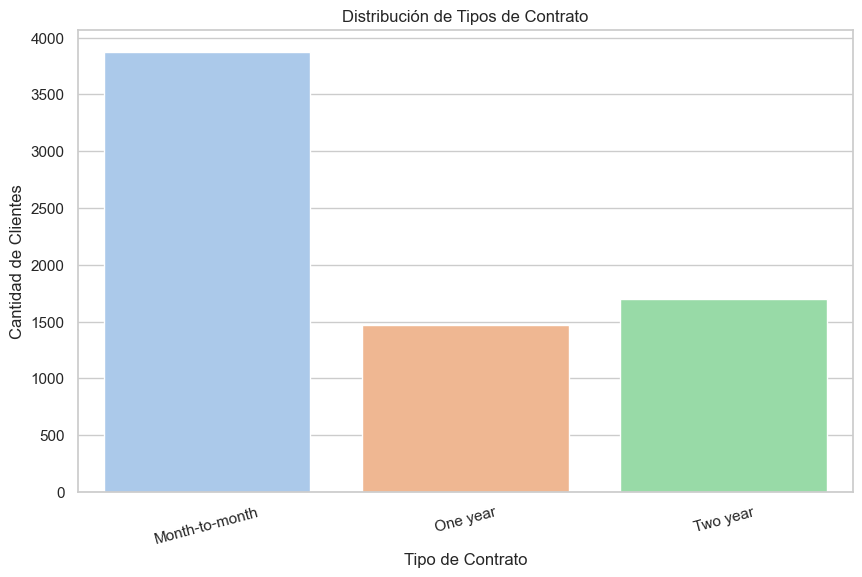

In [9]:
# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Asumo que ya cargaste tu DataFrame como `df_merge`
# Ejemplo: df = pd.read_csv("tu_archivo.csv")

# 1. Distribución de MonthlyCharges por tipo de InternetService
sns.boxplot(data=df_merge, x='internetservice', y='monthlycharges', palette="Set2")
plt.title("Monthly Charges por tipo de Internet Service")
plt.ylabel("Monthly Charges")
plt.xlabel("Internet Service")
plt.show()


# 2. Conteo de contratos (Type)
sns.countplot(data=df_merge, x='type', palette='pastel')
plt.title("Distribución de Tipos de Contrato")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Cantidad de Clientes")
plt.xticks(rotation=15)
plt.show()


Codificaremos las diferentes variables categóricas para poder hacer análisis y entrenamiento posterior:

In [10]:
cat_cols = df_merge.select_dtypes(include=['object', 'category']).columns

# Mostrar los valores únicos por columna
for col in cat_cols:
    print(f"\nValores únicos en '{col}':")
    print(df_merge[col].unique())





Valores únicos en 'customerid':
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

Valores únicos en 'type':
['Month-to-month' 'One year' 'Two year']

Valores únicos en 'paymentmethod':
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Valores únicos en 'internetservice':
['DSL' 'Fiber optic' nan]

Valores únicos en 'gender':
['Female' 'Male']


In [11]:
encoders = {}
mappings = {}
categorical_cols = ['paymentmethod', 'internetservice', 'type', 'gender']

for col in categorical_cols:
    le = LabelEncoder()
    df_merge[col + '_num'] = le.fit_transform(df_merge[col])
    encoders[col] = le
    mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))


print("\n📌 Mapping de LabelEncoder por columna:")
for col, mapping in mappings.items():
    print(f"\n{col}:")
    for key, value in mapping.items():
        print(f"  {key}: {value}")
        
        


📌 Mapping de LabelEncoder por columna:

paymentmethod:
  Bank transfer (automatic): 0
  Credit card (automatic): 1
  Electronic check: 2
  Mailed check: 3

internetservice:
  DSL: 0
  Fiber optic: 1
  nan: 2

type:
  Month-to-month: 0
  One year: 1
  Two year: 2

gender:
  Female: 0
  Male: 1


In [12]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customerid           7043 non-null   object        
 1   begindate            7043 non-null   datetime64[ns]
 2   enddate              1869 non-null   datetime64[ns]
 3   type                 7043 non-null   object        
 4   paperlessbilling     7043 non-null   int64         
 5   paymentmethod        7043 non-null   object        
 6   monthlycharges       7043 non-null   float64       
 7   totalcharges         7043 non-null   int64         
 8   internetservice      5517 non-null   object        
 9   onlinesecurity       5517 non-null   float64       
 10  onlinebackup         5517 non-null   float64       
 11  deviceprotection     5517 non-null   float64       
 12  techsupport          5517 non-null   float64       
 13  streamingtv          5517 non-nul

#### 2.1. Feature Engineering

A modo de generar un modelo que sea capaz de captar la interacción entre varianles no lineales e interacciones sutiles, se crean las siguientes variables para aumentar el valor predictivo:

- `total_services`: suma de todos los servicios contratados.
- `contract_days`: duración del contrato si tienes fecha de inicio y fin.
- `charge_ratio`: proporción entre pagos mensuales y totales (si los tuvieras).
- `senior_with_dependents`: mayores que viven con dependientes.
- `is_single_dependent`: clientes sin pareja pero con dependientes.

In [13]:
df_merge['total_services'] = df_merge[['multiplelines', 'onlinebackup', 'onlinesecurity', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']].sum(axis=1).astype(int)
df_merge['contract_days'] = (df_merge['enddate'] - df_merge['begindate']).dt.days
df_merge['charge_ratio'] = df_merge['monthlycharges'] / df_merge['totalcharges']
df_merge['senior_with_dependents'] = ((df_merge['seniorcitizen'] == 1) & (df_merge['dependents'] == 1)).astype(int)
df_merge['is_single_dependent'] = ((df_merge['seniorcitizen'] == 0) & (df_merge['dependents'] == 1)).astype(int)

df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customerid              7043 non-null   object        
 1   begindate               7043 non-null   datetime64[ns]
 2   enddate                 1869 non-null   datetime64[ns]
 3   type                    7043 non-null   object        
 4   paperlessbilling        7043 non-null   int64         
 5   paymentmethod           7043 non-null   object        
 6   monthlycharges          7043 non-null   float64       
 7   totalcharges            7043 non-null   int64         
 8   internetservice         5517 non-null   object        
 9   onlinesecurity          5517 non-null   float64       
 10  onlinebackup            5517 non-null   float64       
 11  deviceprotection        5517 non-null   float64       
 12  techsupport             5517 non-null   float64 

In [14]:
df_merge.sample(5)

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,churn,paymentmethod_num,internetservice_num,type_num,gender_num,total_services,contract_days,charge_ratio,senior_with_dependents,is_single_dependent
4923,6075-QMNRR,2015-10-01,NaT,Month-to-month,1,Bank transfer (automatic),49.75,1,DSL,1.0,...,0,0,0,0,0,7,NaN,49.75,0,1
4759,8740-CRYFY,2019-11-01,2019-12-01,Month-to-month,1,Electronic check,78.95,1,Fiber optic,1.0,...,1,2,1,0,1,7,30.0,78.95,0,1
4397,7663-YJHSN,2014-02-01,NaT,Two year,1,Bank transfer (automatic),103.95,1,Fiber optic,1.0,...,0,0,1,2,0,7,NaN,103.95,0,1
1253,2026-TGDHM,2019-04-01,2019-11-01,Month-to-month,1,Electronic check,79.30,1,Fiber optic,1.0,...,1,2,1,0,0,7,214.0,79.30,0,1
6132,3896-RCYYE,2014-07-01,NaT,Month-to-month,1,Credit card (automatic),53.40,1,DSL,1.0,...,0,1,0,0,0,6,NaN,53.40,0,1


#### 2.2. Correlación de variables con el churn

/var/folders/y_/4wwc4n5d2b70xpd8w5t_sk3m0000gn/T/ipykernel_4489/645208255.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_merge.fillna(0, inplace=True)


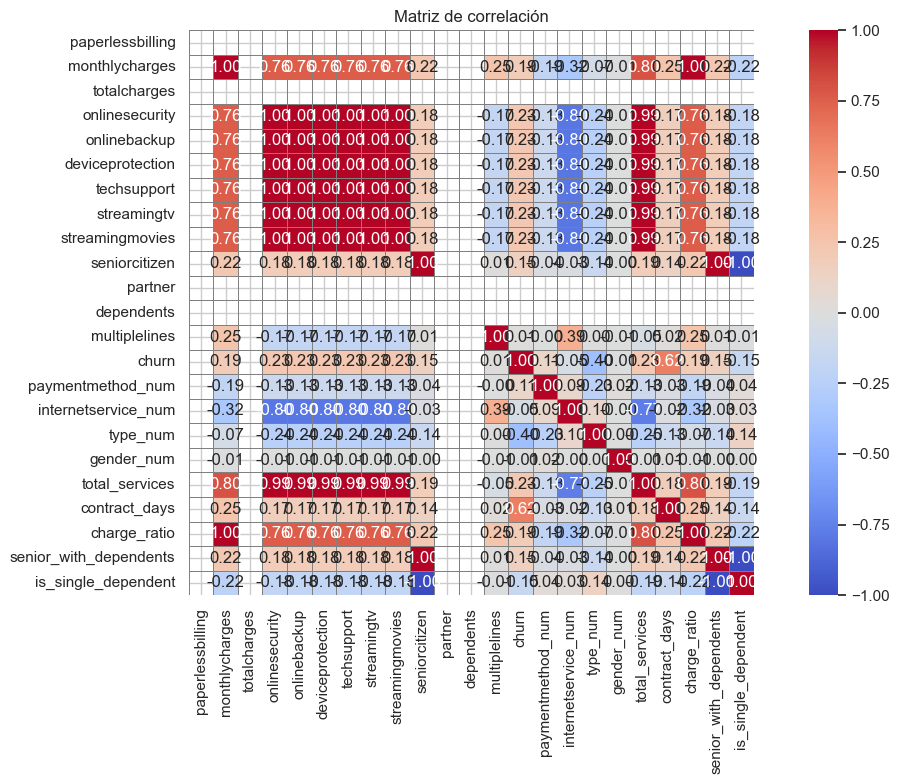

In [15]:
df_merge.fillna(0, inplace=True)
df_numeric = df_merge.select_dtypes(include='number')

corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

In [16]:
corr_matrix["type_num"].sort_values(ascending=False)


type_num                  1.000000
is_single_dependent       0.142554
internetservice_num       0.099721
multiplelines             0.002247
gender_num                0.000126
monthlycharges           -0.074195
charge_ratio             -0.074195
contract_days            -0.131065
seniorcitizen            -0.142554
senior_with_dependents   -0.142554
paymentmethod_num        -0.227543
onlinebackup             -0.242388
onlinesecurity           -0.242388
deviceprotection         -0.242388
streamingmovies          -0.242388
streamingtv              -0.242388
techsupport              -0.242388
total_services           -0.245442
churn                    -0.396713
paperlessbilling               NaN
totalcharges                   NaN
partner                        NaN
dependents                     NaN
Name: type_num, dtype: float64

El valor NaN (Not a Number) en la matriz de correlación generalmente indica que hay columnas que tienen valores constantes o que no contienen variabilidad suficiente para calcular una correlación. Si todas las filas de una columna son iguales, la desviación estándar de esa columna será cero, y como la fórmula para la correlación incluye una división por la desviación estándar, el cálculo no será posible y resultará en NaN.

En este caso, parece que las columnas que están mostrando NaN tienen alguna de estas características:

- Columnas constantes: Si los valores en las columnas son todos iguales para todas las filas, no hay variabilidad para calcular una correlación. Esto hace que su desviación estándar sea cero y, por lo tanto, la correlación no se pueda calcular.

- Valores faltantes: Si las columnas contienen valores faltantes (NaN), el cálculo de la correlación también puede fallar y resultar en NaN, pero esto no es posible dado que anteriormente hicimos fillna con el valor 0.

Para probar que las columnas `paperlessbilling`, `totalcharges`, `partner` y `dependents` tienen valores constantes y no los necesitamos para el análisis, realizamos lo siguiente:

In [17]:
# mostrar las metricas de las columnas sin variacion aparente

for col in df_numeric.columns:
    if df_numeric[col].nunique() == 1:
        print(f"Columna '{col}' tiene una única categoría.")
        print(df_numeric[col].describe())
        print("\n")



Columna 'paperlessbilling' tiene una única categoría.
count    7043.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: paperlessbilling, dtype: float64


Columna 'totalcharges' tiene una única categoría.
count    7043.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: totalcharges, dtype: float64


Columna 'partner' tiene una única categoría.
count    7043.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: partner, dtype: float64


Columna 'dependents' tiene una única categoría.
count    7043.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: dependents, dtype: float64




Como se previó, efectivamente las columnas no tenían variación por lo que las dejaremos fuera del análisis:

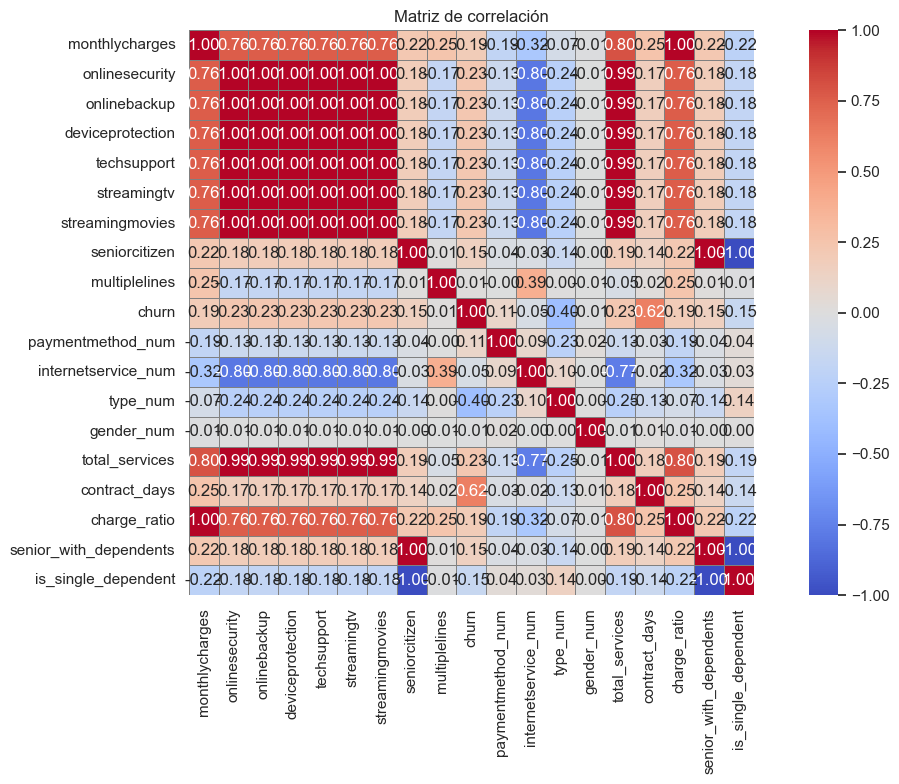

In [18]:
# Eliminar las columnas con solo un valor único
df_merge = df_merge.loc[:, df_merge.nunique() > 1]
df_numeric = df_merge.select_dtypes(include='number')

corr_matrix = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title("Matriz de correlación")
plt.tight_layout()
plt.show()

En relación a la matriz de correlación, es posible concluir que las variables relevantes para el estudio (correlación positiva y negativa > | -0.15 | con la variable objetivo ) son:

- is_single_dependent (0.15)
- senior_with_dependents (0.15)
- charge_ratio (0.19)
- contract_days (0.62)
- Type (-0.4)
- Payment method(0.11)
- senior citizen (0.15)
- Servicios (0.23): streaming movies, streaming tv, etc...
- Monthly Charge (0.19)

#### 2.2. Estudio del balance de clases

Número de clientes fugados: churn
0    5174
1    1869
Name: count, dtype: int64
Proporción de los clientes fugados: churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


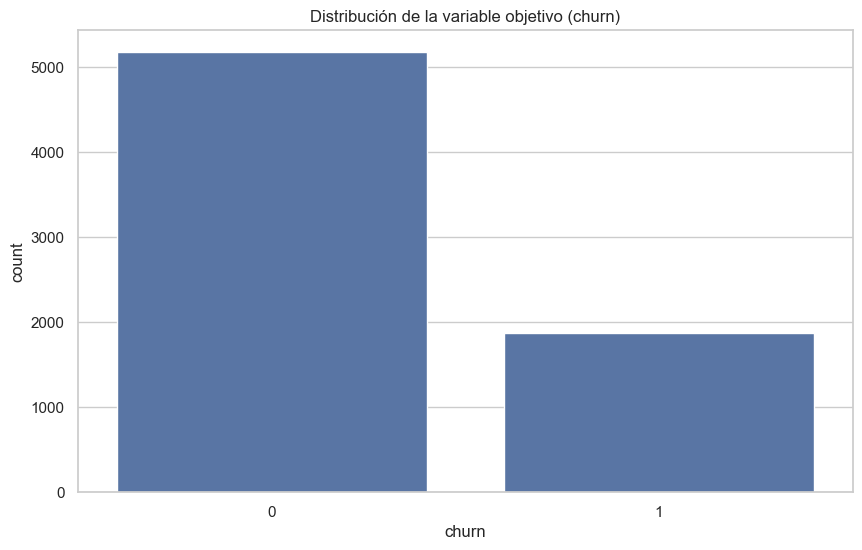

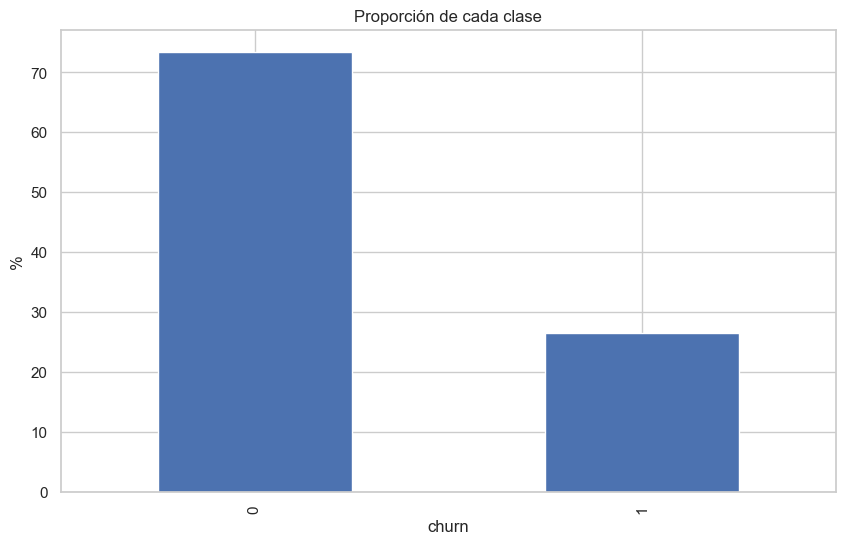

In [19]:
print(f'Número de clientes fugados: {df_merge['churn'].value_counts()}')
print(f'Proporción de los clientes fugados: {df_merge['churn'].value_counts(normalize=True)}')

sns.countplot(x='churn', data=df_merge)
plt.title('Distribución de la variable objetivo (churn)')
plt.show()


(df_merge['churn'].value_counts(normalize=True) * 100).plot(kind='bar')
plt.ylabel('%')
plt.title('Proporción de cada clase')
plt.show()


Dada que existe una desproporción en las clases de fugados y no fugados, debemos aplicar técnicas de balanceo de clases, lo cual podemos conseguir usando  SMOTE+Tomek (aumento de la clase minoritaria).

### 3. Modelado

Para esta sección del documento, desarrollaremos el modelo predictor de fuga a partir del data frame `df_merge` preparado previamente. Las decisiones tomadas para el desarrollo se presentan a continuación:

- Separación 20/80 conjunto de prueba y entrenamiento
- Validación cruzada:  asegura de que la división entre los conjuntos de entrenamiento y prueba mantenga una proporción similar de las clases o categorías presentes en los datos
- Modelos a probar iteración 1:
    - Regresión logística
    - Random Forest
    - Gradient Boosting
    - AdaBoost
- Técnicas de resampling:
    - SMOTEENN (SMOTE + Edited Nearest Neighbors): Aumenta la clase minoritaria con datos sintéticos y luego elimina ejemplos ruidosos que podrían confundir al modelo
        - SMOTE (Synthetic Minority Over-sampling Technique):
            - Genera ejemplos sintéticos de la clase minoritaria interpolando entre observaciones reales cercanas.
        - ENN (Edited Nearest Neighbors):
            - Elimina instancias (de cualquier clase) cuyos vecinos más cercanos tienen una clase diferente. Se usa para limpiar el ruido del dataset.

    - SMOTETomek (SMOTE + Tomek Links):
        - Tomek Links:
            - Identifica pares de instancias cercanas pero de diferentes clases (posiblemente ubicadas en la frontera de decisión).
            - Elimina la instancia mayoritaria de ese par para refinar la separación entre clases.
- Estandarizado de la Data usando `StandardScaler`
- Evaluación de los modelos mediante:
    - ROC-AUC
    - Confusion Matrix
    - Classification Report


Definción de funciones a utilizar en el modelado

1. Análisis del _thresholds_

In [20]:
def analyze_thresholds(y_true, y_proba, plot=True):
    # Métrica ROC-AUC general (con las probabilidades)
    roc_auc = roc_auc_score(y_true, y_proba)

    # Calcular precision, recall, f1 para varios thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-8)

    # Mejor threshold según F1
    best_idx = f1_scores.argmax()
    best_threshold = thresholds[best_idx]
    y_pred_adjusted = (y_proba >= best_threshold).astype(int)

    # Resultados
    print(f"\n🎯 Mejor threshold según F1: {best_threshold:.2f}")
    print("Classification Report con threshold ajustado:")
    print(classification_report(y_true, y_pred_adjusted))

    # Gráfico
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
        plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
        plt.plot(thresholds, f1_scores, "r-", label="F1 Score")
        plt.axvline(x=0.5, color='gray', linestyle=':', label='Threshold 0.5')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Mejor threshold: {best_threshold:.2f}')
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title("Precision, Recall y F1 vs Threshold")
        plt.legend()
        plt.grid(True)
        plt.show()


2. Evaluación de los modelos

In [21]:
def evaluate_models_with_resampling(
    X_train, X_test, y_train, y_test,
    models, resamplers=None, param_grids=None,
    cv=5, threshold_analysis=False, plot_threshold=False
):
    if param_grids is None:
        param_grids = {}

    if not resamplers:
        resamplers = {"Sin resampling": None}

    for resampler_name, resampler in resamplers.items():
        print(f"\n📌 Usando {resampler_name}")
        
        for model_name, model in models.items():
            print(f"\n🔍 Modelo: {model_name}")
            
            steps = [("scaler", StandardScaler())]
            if resampler is not None:
                steps.append(("resampler", resampler))
            steps.append(("model", model))
            
            pipeline = ImbPipeline(steps)
            param_grid = param_grids.get(model_name, {})
            
            grid_search = GridSearchCV(
                pipeline,
                param_grid=param_grid,
                cv=cv,
                scoring='roc_auc',
                n_jobs=-1,
                verbose=0
            )
            
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning, message=".*does not have valid feature names.*")
                grid_search.fit(X_train, y_train)

            best_pipeline = grid_search.best_estimator_
            best_params = grid_search.best_params_
            
            print(f"📈 Mejor combinación de hiperparámetros: {best_params}")
            print(f"ROC-AUC (CV mejor modelo): {grid_search.best_score_:.4f}")
            
            y_pred = best_pipeline.predict(X_test)
            y_proba = best_pipeline.predict_proba(X_test)[:, 1]
            
            print("Classification Report:")
            print(classification_report(y_test, y_pred))
            print("Confusion Matrix:")
            print(confusion_matrix(y_test, y_pred))
            print(f"ROC-AUC (test): {roc_auc_score(y_test, y_proba):.4f}")
            warnings.filterwarnings("ignore", category=UserWarning)

            
            if threshold_analysis:
                print("\n⚖️ Ajuste de Threshold según ROC-AUC:")
                analyze_thresholds(y_test, y_proba, plot_threshold)


#### 3.1. Primera iteración del modelo

Probaremos el desempeño de los siguientes modelos que son más simples y con un costo operacional menor:
- Regresión logística
- Random Forest
- Gradient Boosting
- AdaBoost

In [22]:
df_merge = df_merge.select_dtypes(include='number')
X = df_merge.drop("churn", axis=1)
y = df_merge["churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
    
}

resamplers = {
    "Sin resample": None,
    "SMOTETomek": SMOTETomek(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42)
}


In [23]:
evaluate_models_with_resampling(X_train, X_test, y_train, y_test,
    models, resamplers=resamplers, param_grids=None,
    cv=cv, threshold_analysis=False, plot_threshold=False)


📌 Usando Sin resample

🔍 Modelo: Logistic Regression


📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 0.9984
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1294
           1       1.00      0.87      0.93       467

    accuracy                           0.97      1761
   macro avg       0.98      0.94      0.96      1761
weighted avg       0.97      0.97      0.97      1761

Confusion Matrix:
[[1294    0]
 [  59  408]]
ROC-AUC (test): 0.9967

🔍 Modelo: Random Forest
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC 

Como se aprecia en los resultados anteriores, se obtuvieron buenas métricas generales. Si somos más precisos, los tres mejores modelos overall son:

1. Sin resample:

- Modelo Random Forest:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo AdaBoost:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo  Gradient Boosting:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00

2. Con resample SMOTETomek:

- Modelo Random Forest:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo AdaBoost:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo  Gradient Boosting:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
3. Con resample SMOTEENN

- Modelo Random Forest:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo AdaBoost:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00
- Modelo  Gradient Boosting:
    - ROC-AUC (test): 1.0000
    - precision: 1.00
    - recall: 1.00
    - f1-score : 1.00


Con estos resultados, cualquier modelo que se elija de aqui es idóneo para el objetivo de predicción de fuga y el conjunto de datos entregado. Por robustez del modelo, se sugiere usar  Gradient Boosting o AdaBoost con ténica de resample SMOOTEN.


#### 3.2. Segunda iteración del modelo

Si bien los resultados no admiten mejora (ROC-AUC = 1.0), haremos el ejercicio teórico de los pasos para mejorar este indicador:

- Eliminar variables del df que no tengan tanta correlación con la variable de estudio
- Probar otros modelos de balance de clases
- Variar hiperparámetros de los modelos
- Ajustar el threshold
- Probar otros modelos más potentes


##### 3.2.1. Dropeo de características innecesarias

Se revisará si eliminar las variables numérica con menor correlación (< 0.01) mejora el modelo al reducir el ruido:

In [24]:
df_features_no_corr2 = df_merge.drop(columns=["gender_num", "type_num"], axis=1)

In [25]:

X_2 = df_features_no_corr2.drop("churn", axis=1)
y_2 = df_features_no_corr2["churn"]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.25, stratify=y, random_state=42
)

Probemos si existe mejora en el rendimiento:

In [26]:
evaluate_models_with_resampling(X_train_2, X_test_2, y_train_2, y_test_2,
    models, resamplers=resamplers, param_grids=None,
    cv=cv, threshold_analysis=False, plot_threshold=False)


📌 Usando Sin resample

🔍 Modelo: Logistic Regression
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 0.9952
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1294
           1       1.00      0.87      0.93       467

    accuracy                           0.96      1761
   macro avg       0.98      0.93      0.95      1761
weighted avg       0.97      0.96      0.96      1761

Confusion Matrix:
[[1294    0]
 [  62  405]]
ROC-AUC (test): 0.9948

🔍 Modelo: Random Forest


📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

🔍 Modelo: AdaBoost
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test

Al eliminar las varaiables con menor correlación no se percibe mejora, por lo que avanzaremos con la siguiente técnica de mejora del modelo. 

#### 3.2.2. Otras técnicas de balance de clase

Probaremos usar técnicas menos sofisticadas de desquilibrio de clase como el Oversampling y el Undersampling

In [27]:
resamplers_over_under = {
    "Oversampling": RandomOverSampler(random_state=42),
    "Undersampling": RandomUnderSampler(random_state=42)
}

In [28]:
evaluate_models_with_resampling(X_train, X_test, y_train, y_test,
    models, resamplers=resamplers_over_under, param_grids=None,
    cv=cv, threshold_analysis=False, plot_threshold=False)


📌 Usando Oversampling

🔍 Modelo: Logistic Regression
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1294
           1       1.00      0.97      0.99       467

    accuracy                           0.99      1761
   macro avg       1.00      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761

Confusion Matrix:
[[1294    0]
 [  13  454]]
ROC-AUC (test): 0.9987

🔍 Modelo: Random Forest


📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

🔍 Modelo: AdaBoost
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test

Tampoco existe una mejora variando el método de balanceo de clases.

#### 3.2.3. Variación del threshold

Si bien el ROC-AUC (Área bajo la curva ROC) no depende del threshold, este tipo de análisis mejora métricas secundarias como:
- Precision
- Recall
- F1
- Accuracy
- Matriz de confusión




📌 Usando Oversampling

🔍 Modelo: Logistic Regression
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 0.9996
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1294
           1       1.00      0.97      0.99       467

    accuracy                           0.99      1761
   macro avg       1.00      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761

Confusion Matrix:
[[1294    0]
 [  13  454]]
ROC-AUC (test): 0.9987

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.49
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1294
           1       1.00      0.97      0.99       467

    accuracy                           0.99      1761
   macro avg       0.99      0.99      0.99      1761
weighted avg       0.99      0.99      0.99      1761



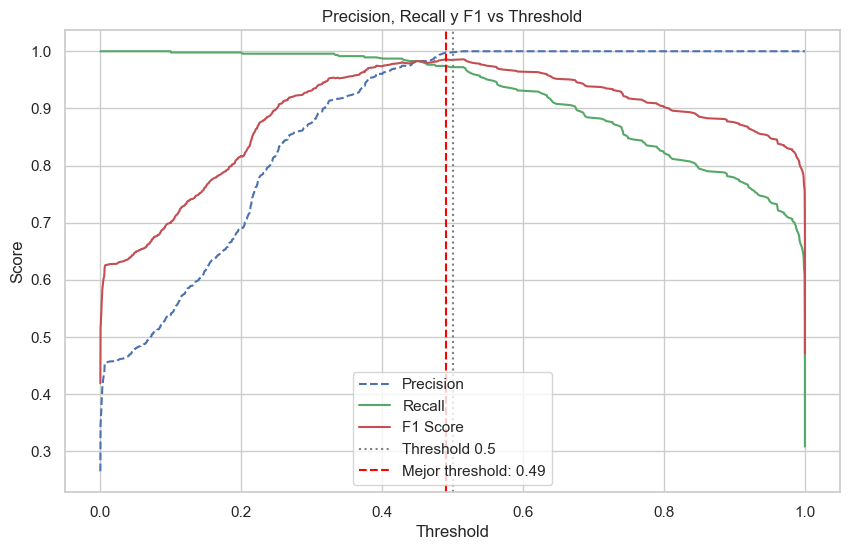


🔍 Modelo: Random Forest
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.55
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



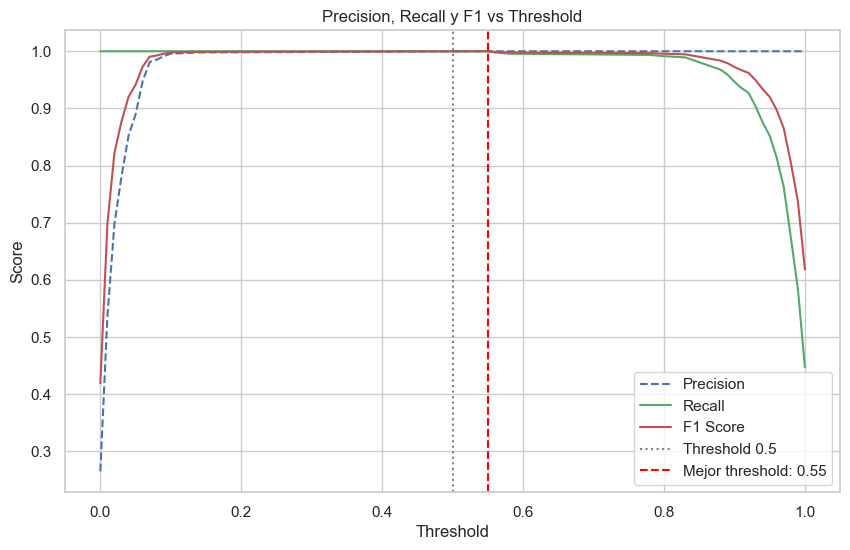


🔍 Modelo: AdaBoost
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.88
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



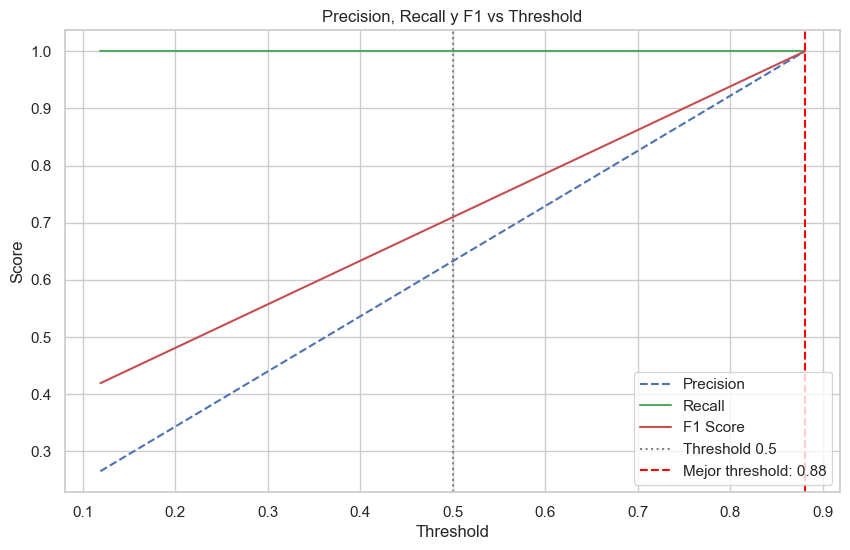


🔍 Modelo: Gradient Boosting
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 1.00
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



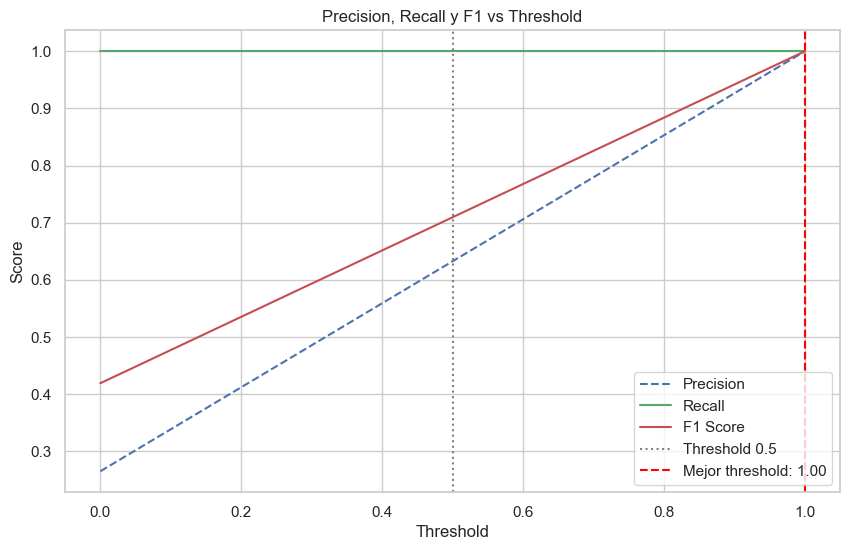


📌 Usando Undersampling

🔍 Modelo: Logistic Regression
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 0.9964
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1294
           1       0.95      0.92      0.94       467

    accuracy                           0.97      1761
   macro avg       0.96      0.95      0.96      1761
weighted avg       0.97      0.97      0.97      1761

Confusion Matrix:
[[1273   21]
 [  37  430]]
ROC-AUC (test): 0.9947

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.48
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1294
           1       0.95      0.94      0.95       467

    accuracy                           0.97      1761
   macro avg       0.96      0.96      0.96      1761
weighted avg       0.97      0.97      0.97      1761



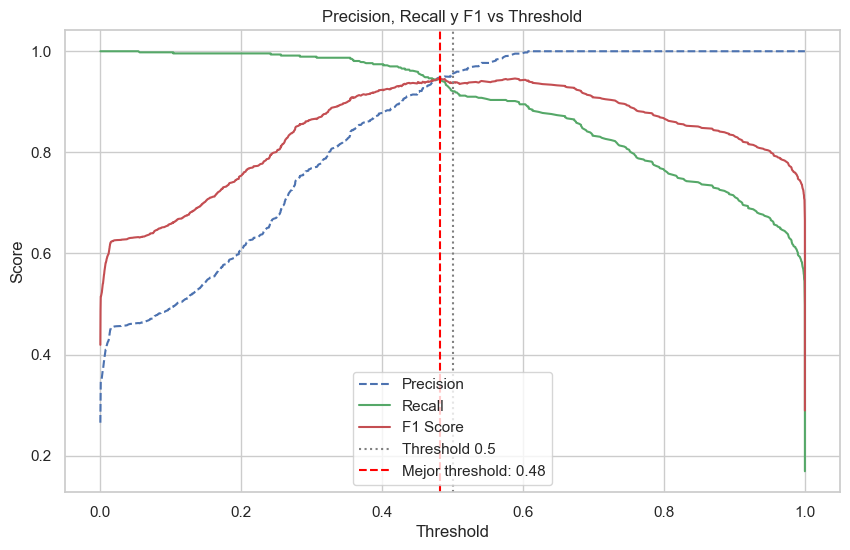


🔍 Modelo: Random Forest
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.52
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



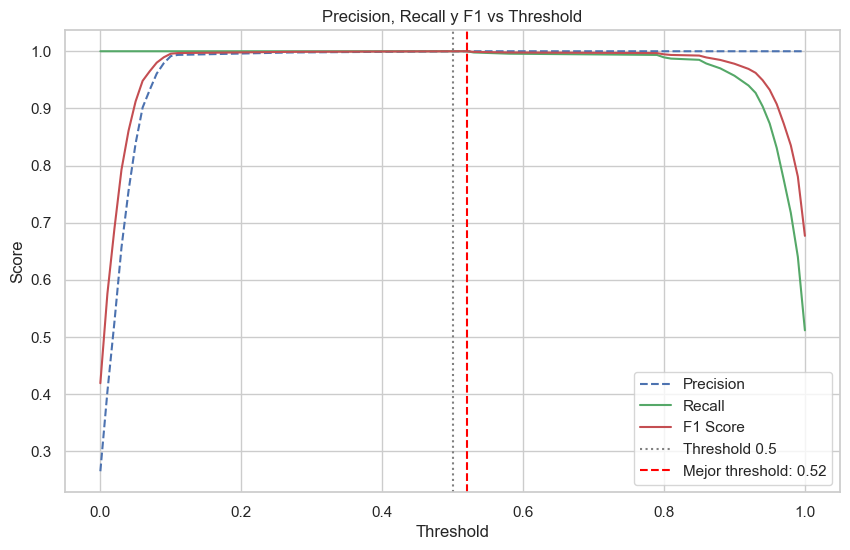


🔍 Modelo: AdaBoost
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 0.88
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



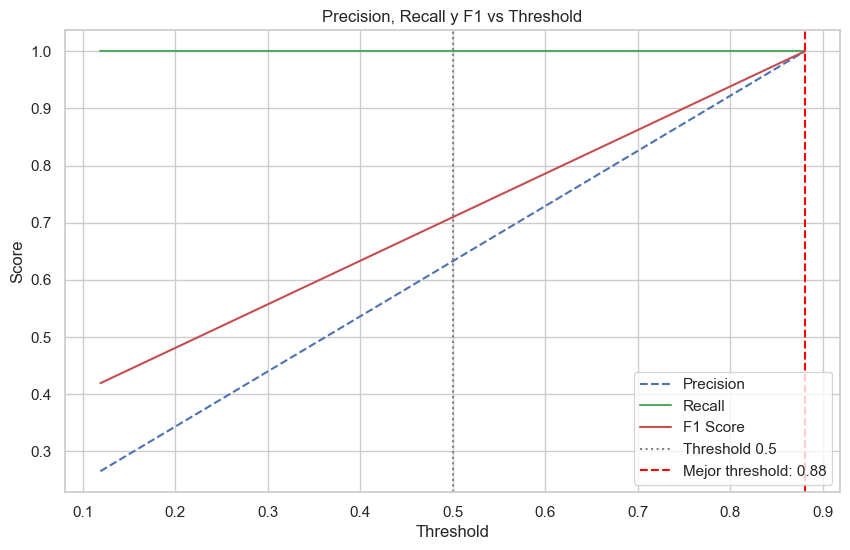


🔍 Modelo: Gradient Boosting
📈 Mejor combinación de hiperparámetros: {}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

⚖️ Ajuste de Threshold según ROC-AUC:

🎯 Mejor threshold según F1: 1.00
Classification Report con threshold ajustado:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761



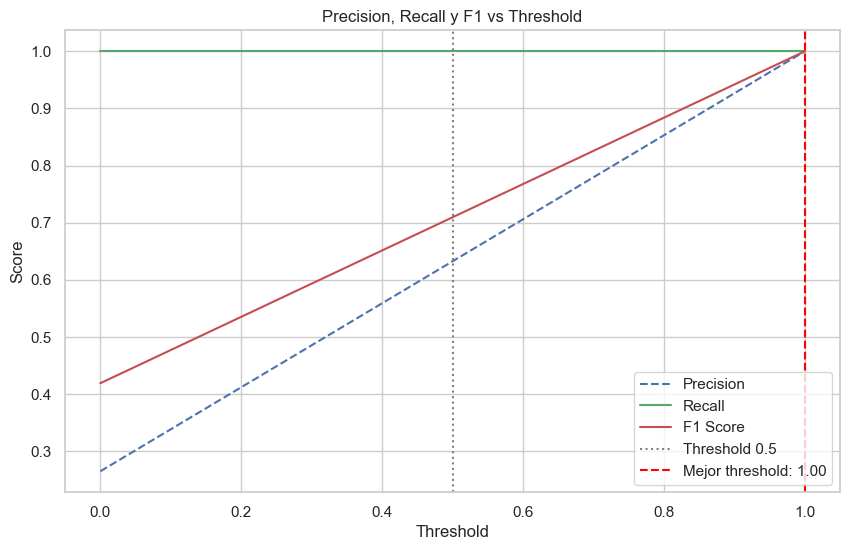

In [29]:
evaluate_models_with_resampling(X_train, X_test, y_train, y_test,
    models, resamplers=resamplers_over_under, param_grids=None,
    cv=cv, threshold_analysis=True, plot_threshold=True)

#### 3.2.4. Variación de hiperparámetros 

In [30]:

param_grids = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"]
    },
    "Random Forest": {
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 1]
    },
    "Gradient Boosting": {
        "model__n_estimators": [100, 200],
        "model__learning_rate": [0.01, 0.1],
        "model__max_depth": [3, 5, 10]
    }
}

In [31]:
evaluate_models_with_resampling(X_train, X_test, y_train, y_test,
    models, resamplers=resamplers, param_grids=param_grids,
    cv=cv, threshold_analysis=False, plot_threshold=False)



📌 Usando Sin resample

🔍 Modelo: Logistic Regression


📈 Mejor combinación de hiperparámetros: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      0.99      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   4  463]]
ROC-AUC (test): 1.0000

🔍 Modelo: Random Forest
📈 Mejor combinación de hiperparámetros: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg   

Con la variación de los hiperparámetros conseguimos mejorar incluso al modelo Logistic Regression que alcanzó un AUC-ROC de `1.0` .

#### 3.2.5. Uso de modelos más complejos
 
Usaremos:
- XGBoost (con param_grid)
- LightGBM
- CatBoost
- StackingClassifier
- VotingClassifier (ensamble suave)

In [32]:
models = {
    "XGBoost": XGBClassifier(eval_metric="auc", random_state=42),  
}

param_grids = {
    "XGBoost": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [3, 5],
        "model__learning_rate": [0.01, 0.1],
        "model__subsample": [0.8, 1.0]
    },
    "LightGBM": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [-1, 5],
        "model__learning_rate": [0.01, 0.1],
        "model__num_leaves": [31, 50],
        "model__verbose": [-1]
    },
    "CatBoost": {
        "model__iterations": [100, 200],
        "model__depth": [3, 5],
        "model__learning_rate": [0.01, 0.1]
    },
    "Stacking": {},  
    "Voting": {}    
}




In [33]:
evaluate_models_with_resampling(X_train, X_test, y_train, y_test,
    models, resamplers=resamplers, param_grids=param_grids,
    cv=5, threshold_analysis=False, plot_threshold=False)



📌 Usando Sin resample

🔍 Modelo: XGBoost


📈 Mejor combinación de hiperparámetros: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00       467

    accuracy                           1.00      1761
   macro avg       1.00      1.00      1.00      1761
weighted avg       1.00      1.00      1.00      1761

Confusion Matrix:
[[1294    0]
 [   0  467]]
ROC-AUC (test): 1.0000

📌 Usando SMOTETomek

🔍 Modelo: XGBoost
📈 Mejor combinación de hiperparámetros: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
ROC-AUC (CV mejor modelo): 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1294
           1       1.00      1.00      1.00     

Como era de esperarse, usar modelos más potentes como lo son `XGBoost (con param_grid), LightGBM, CatBoost, StackingClassifier y VotingClassifier (ensamble suave)` generan resultados igual de buenos que los utilizados en la primera iteración.

4. Conclusiones

A modo de conclusión y de acuerdo a lo desarrollado en este informe, se logró entrenar y testar diversos modelos de predicción de fuga obteniéndose resultados satisfactorios (AUC-ROC = 1.0) para diferentes combinaciones de modelos e hiperparámetros. A modo de recomendación final, el modelo que se puede utilizar para este conjunto de datos y el problema escogido es el de Gradient Boosting ya que es más robusto ante outliers, tiene mejor regularización (shrinkage, subsampling) y es más preciso. Se recomienda mantener los hiperparámetros de la iteración 1 y utilizar la técnica de sampling SOMOTE.